# Image Processing Assignment 3: Binary images

Before we start, please put your names and IDs in following format

: Firstname LASTNAME, #00000000   //   (e.g.) Dana LEVI, #12345678

**Your Answer:**   
Mark Sheinberg #324078708 // Bar Aharon #209163708

In this exercise, you will implement **Binary Images** algorithms.

Methods: as explained in class.

Notes:
*   Write your code in the dedicated areas (TODO blocks). You can add helper functions.
*   Submission email should include a link to the Colab submission notebook located on your Google Drive with Commenter access right to nev1958a@gmail.com
*   The solution notebook should be able to be run (‘Run all’) with no errors.
In case of errors, the submission will be disqualified.
*   The grade will depend on correct performance on several grayscale images and on clean programming and documentation.
*   Do not forget to add the Names and Student I.D. at the top of the notebook.
*   All images are given as 2-dimensional matrices of type `float`, with values in the range [0..1].
*   Pay Attention! In the following functions, the returned images must be the same size as the original Images!

Please implement the following functions:
1. Write the `tag_connected_components` function which finds the connected components in a binary image and returns a matrix with the same size in which each connected component is tagged with a different label. The tags should be sequential.
2. Write the `skeletonizeImage` function which skeletonizes objects in a given binary image and returns the new binary image.

**Note** In these images, **1** represents the object, and **0** (black) represents the background.

## Setup Code
Before getting started, we need to run some boilerplate code to set up our environment. You will need to rerun this setup code each time you start the notebook.

In [1]:
import os
import requests
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
import PIL

In [2]:
GITHUB_PATH = 'https://raw.githubusercontent.com/dnevo/ImageProcessing/main/images/'

In [3]:
def read_file(file_name:str, file_path:str=GITHUB_PATH) -> np.ndarray:
    '''
    Accept an image file name (defaulty located in GitHub) and return the image
    in a numpy array.

    Args:
        file_name: the file name
        file_path: the file path.. Default value is Doron's Github repo.

    Returns:
        the image converted into a Numpy array.
    '''
    file_path = os.path.join(file_path, file_name)
    response = requests.get(file_path)
    fp = BytesIO(response.content)

    img_pil = PIL.Image.open(fp)
    return np.array(img_pil, dtype='int16')

In [4]:
def pretty_print(img):
    ''' pretty printing of binary imagees and connected components - by
    replacing zeros with whitespaces.
    Args:
        img: image in float format (range: 0..1) - the source binary image
        file_path: the file path.. Default value is Doron's Github repo.

    Returns:
        the image converted into a Numpy array.
    '''
    for r in range(img.shape[0]):
        l = [str(img[r,c].astype(np.int16)) if img[r,c]>0 else ' ' for c in range(img.shape[1])]
        print(''.join(map(str, l)))

In [5]:
def plot_images(img1:np.array, img2:np.array):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
    axes[0].imshow(img1,  cmap='gray')
    axes[1].imshow(img2,  cmap='gray')

## `tag_connected_components`

In [6]:
def tag_connected_components(img: np.array) -> np.array:
    '''
    This function receives a binary image and finds the connected components
    in it and returns a matrix with the same size in which each connected
    componnent is tagged with a different label. The tags should be sequential.

    Args:
        img: image in float format (range: 0..1) - the source binary image

    Returns:
        img_new: in float format - the image with components tagging in a
        2-dimensional matrice
    '''
    ######################################################################
    # TODO: Implement The tag connected components algorithm.
    ######################################################################

    maxtag = 0
    equiv_vec = []
    nrows, ncols = img.shape
    img_new = np.zeros((nrows, ncols))

    # First pass: Assign preliminary labels and build equivalence relationships
    for r in range(1, nrows - 1):
        for c in range(1, ncols - 1):
            if img[r, c] == 0:
                continue

            # Get the labels of the neighboring pixels (above and left)
            above = img_new[r - 1, c]
            left = img_new[r, c - 1]

            # No labeled neighbors (new component)
            if above == 0 and left == 0:
                maxtag += 1
                equiv_vec.append((maxtag, maxtag))
                img_new[r, c] = maxtag

            # Only the pixel above is labeled
            elif above > 0 and left == 0:
                img_new[r, c] = above

            # Only the pixel to the left is labeled
            elif above == 0 and left > 0:
                img_new[r, c] = left

            # Both neighbors are labeled and have the same tag
            elif above > 0 and left > 0 and above == left:
                img_new[r, c] = above

            # Both neighbors are labeled but have different tags
            elif above > 0 and left > 0 and above != left:
                img_new[r, c] = above

                equiv_vec.append([int(above), int(left)])
                equiv_vec.append([int(left), int(above)])

    # Create an equivalence table (clique matrix) of size maxtag x maxtag
    I = np.zeros((maxtag, maxtag))
    for tag1, tag2 in equiv_vec:
        I[tag1 - 1, tag2 - 1] = 1

    # Resolve equivalences by matrix multiplication until convergence
    while True:
        I2 = I @ I
        I2 = np.minimum(I2, 1)
        if (I == I2).all():
            break
        I = I2

    # Repeat matrix multiplication for final equivalence resolution
    I2 = I
    while True:
        I = I2
        I2 = I @ I
        I2 = np.minimum(I2, 1)
        if (I == I2).all():
            break

    # Finalize the equivalence table (binary matrix)
    I2 = np.minimum(I2, 1)

    # Build the conversion vector to map old tags to new sequential tags
    cv = I2[0, :]
    tagmin = 1
    cv_len = len(cv)
    for i in range(1, cv_len):
        if cv[i] == 0:
            tagmin += 1
            cv = cv + tagmin * I2[i, :]

    # Second pass: Assign final labels to the image
    for r in range(1, nrows):
        for c in range(1, ncols):
            if img_new[r, c] > 0:
                # Update it to the final label using the conversion vector
                img_new[r, c] = cv[int(img_new[r, c]) - 1]


    ######################################################################
    #                            END OF YOUR CODE                        #
    ######################################################################

    return img_new

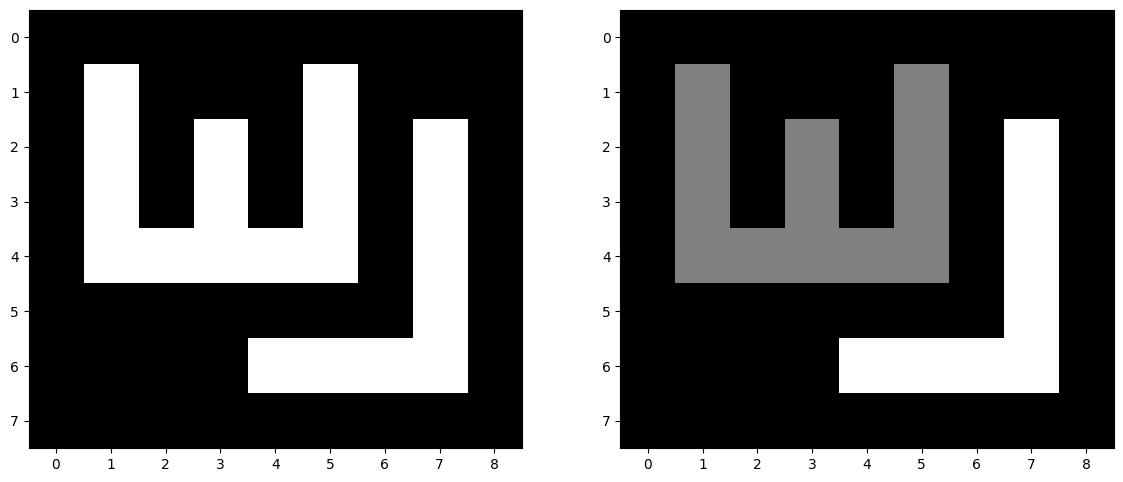

In [7]:
img = np.array([[0,0,0,0,0,0,0,0,0],
       [0,1,0,0,0,1,0,0,0],
       [0,1,0,1,0,1,0,1,0],
       [0,1,0,1,0,1,0,1,0],
       [0,1,1,1,1,1,0,1,0],
       [0,0,0,0,0,0,0,1,0],
       [0,0,0,0,1,1,1,1,0],
       [0,0,0,0,0,0,0,0,0]])
img_n = tag_connected_components(img)
plot_images(img, img_n)

In [8]:
pretty_print(img_n)

         
 1   1   
 1 1 1 2 
 1 1 1 2 
 11111 2 
       2 
    2222 
         


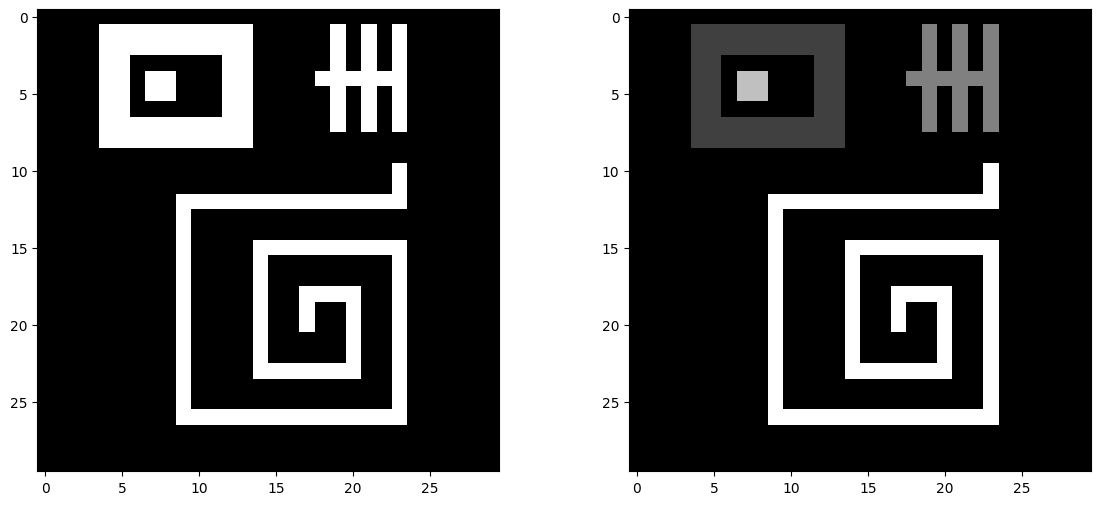

In [9]:
img = read_file('binary1.tiff') / 255
img_n = tag_connected_components(img)
plot_images(img, img_n)

In [10]:
pretty_print(img_n)

                              
    1111111111     2 2 2      
    1111111111     2 2 2      
    11      11     2 2 2      
    11 33   11    222222      
    11 33   11     2 2 2      
    11      11     2 2 2      
    1111111111     2 2 2      
    1111111111                
                              
                       4      
                       4      
         444444444444444      
         4                    
         4                    
         4    4444444444      
         4    4        4      
         4    4        4      
         4    4  4444  4      
         4    4  4  4  4      
         4    4  4  4  4      
         4    4     4  4      
         4    4     4  4      
         4    4444444  4      
         4             4      
         4             4      
         444444444444444      
                              
                              
                              


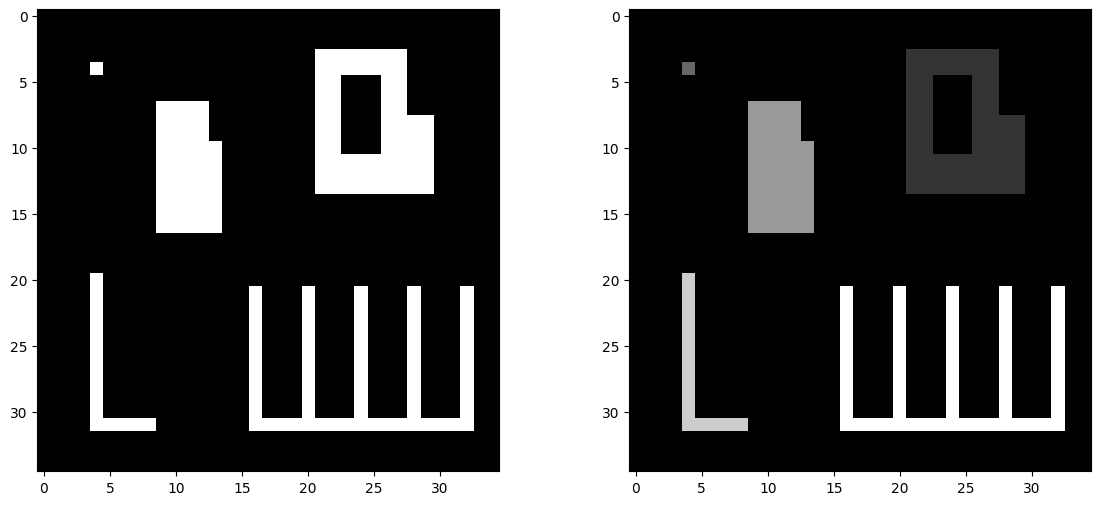

In [11]:
img = read_file('binary2.tiff') / 255
img_n = tag_connected_components(img)
plot_images(img, img_n)

In [12]:
pretty_print(img_n)

                                   
                                   
                                   
                     1111111       
    2                1111111       
                     11   11       
                     11   11       
         3333        11   11       
         3333        11   1111     
         3333        11   1111     
         33333       11   1111     
         33333       111111111     
         33333       111111111     
         33333       111111111     
         33333                     
         33333                     
         33333                     
                                   
                                   
                                   
    4                              
    4           5   5   5   5   5  
    4           5   5   5   5   5  
    4           5   5   5   5   5  
    4           5   5   5   5   5  
    4           5   5   5   5   5  
    4           5   5   5   5   5  
    4           5   5   5   

## `skeletonizeImage `

In [13]:
def skeletonizeImage (img: np.array) -> np.array:
    '''
    This function receives a binary image and finds the connected components
    in it and returns a new binary image with skeletonize objects.

    Args:
        img: image in float format (range: 0..1) - the source binary image

    Returns:
        img_new: in float format (range: 0..1) - the image with skeleton
                    in a 2 dimensional matrice.
    '''
    ######################################################################
    # TODO: Implement The skeletonize algorithm.
    ######################################################################

  # Create the distances matrix
    img = img.astype(int)  # Ensure binary input
    nrows, ncols = img.shape
    dists = img.copy()
    dist = 0
    dist_changed = True

    while dist_changed:
        dist += 1
        dist_changed = False
        for r in range(nrows):
            for c in range(ncols):
                if img[r, c] == 0:
                    continue
                # Check the neighbors
                neighbors = [
                    dists[r-1, c] if r > 0 else 0,  # above
                    dists[r+1, c] if r < nrows-1 else 0,  # below
                    dists[r, c-1] if c > 0 else 0,  # left
                    dists[r, c+1] if c < ncols-1 else 0,  # right
                ]
                if min(neighbors) >= dist:
                    dists[r, c] = dist + 1
                    dist_changed = True

    # Mark the skeleton pixels
    img_new = np.zeros_like(dists, dtype=float)
    for r in range(nrows):
        for c in range(ncols):
            if dists[r, c] > 0:
                # Get neighbors' distances
                neighbors = [
                    dists[r-1, c] if r > 0 else 0,  # above
                    dists[r+1, c] if r < nrows-1 else 0,  # below
                    dists[r, c-1] if c > 0 else 0,  # left
                    dists[r, c+1] if c < ncols-1 else 0,  # right
                ]
                # Check if current pixel is greater than or equal to all its neighbors
                if dists[r, c] >= max(neighbors):
                    img_new[r, c] = 1.0


    ######################################################################
    #                            END OF YOUR CODE                        #
    ######################################################################
    return img_new

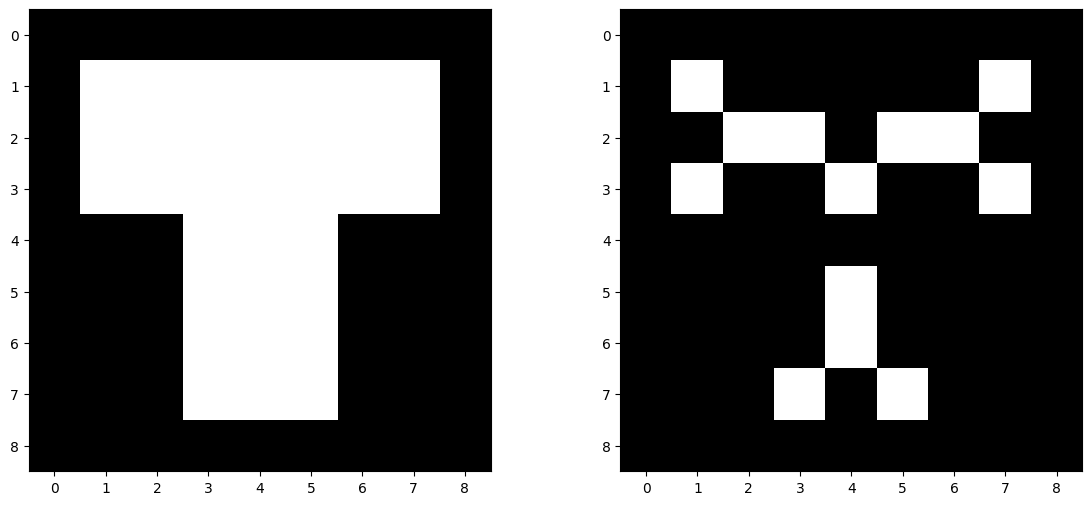

In [14]:
img = np.array([[0,0,0,0,0,0,0,0,0],
                [0,1,1,1,1,1,1,1,0],
                [0,1,1,1,1,1,1,1,0],
                [0,1,1,1,1,1,1,1,0],
                [0,0,0,1,1,1,0,0,0],
                [0,0,0,1,1,1,0,0,0],
                [0,0,0,1,1,1,0,0,0],
                [0,0,0,1,1,1,0,0,0],
                [0,0,0,0,0,0,0,0,0]])
img_new = skeletonizeImage(img)
plot_images(img, img_new)

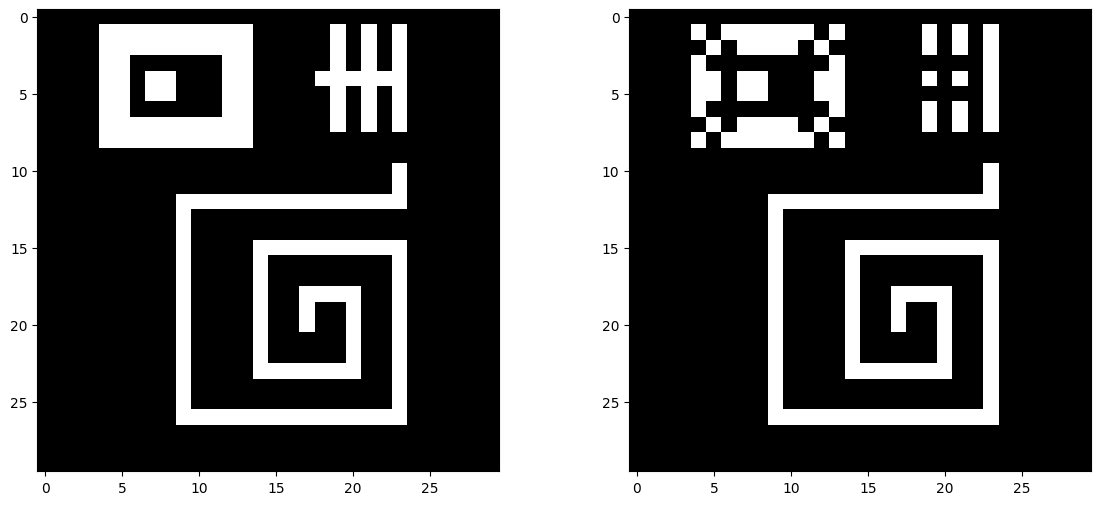

In [15]:
img = read_file('binary1.tiff') / 255
img_n = skeletonizeImage(img)
plot_images(img, img_n)

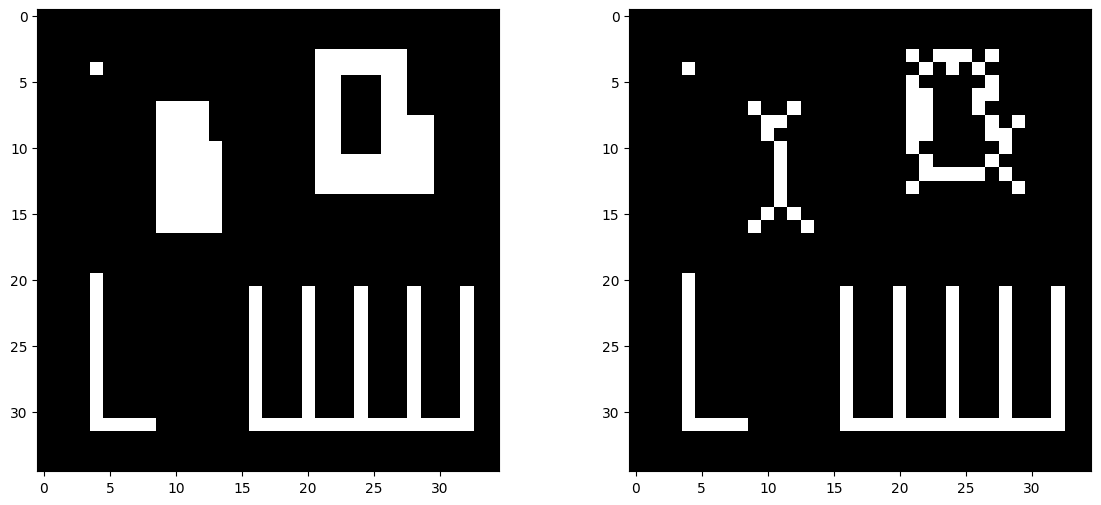

In [16]:
img = read_file('binary2.tiff') / 255
img_n = skeletonizeImage(img)
plot_images(img, img_n)